# Predictive modeling
## Environment Setup

In [1]:
import findspark
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler,StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, LinearSVC, GBTClassifier, FMClassifier
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder

findspark.init()
spark=SparkSession.builder.master ("local[*]").appName("mini_proj_2").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/11/16 00:56:28 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
sc=spark.sparkContext

In [3]:
df=spark.read \
 .option("header","True")\
 .option("inferSchema","True")\
 .option("sep",";")\
 .csv("../data/XYZ_Bank_Deposit_Data_Classification.csv")
print("There are",df.count(),"rows",len(df.columns),
      "columns" ,"in the data.")

There are 41188 rows 21 columns in the data.


In [4]:
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- emp.var.rate: double (nullable = true)
 |-- cons.price.idx: double (nullable = true)
 |-- cons.conf.idx: double (nullable = true)
 |-- euribor3m: double (nullable = true)
 |-- nr.employed: double (nullable = true)
 |-- y: string (nullable = true)



## Data Preparation

In [5]:
# remove . from column names to make easier to work with
new_names = [i.replace('.', '') for i in df.columns]
df = df.toDF(*new_names)

In [6]:
# List of columns to encode
encode_list = [i[0] for i in df.dtypes if (i[1] == 'string') & (i[0] != 'y')]

In [7]:
# encode string columns
indices = {}
for column in encode_list:
    # string indexing
    indexer_fitted = StringIndexer(inputCol=column, outputCol=column + 'Index').fit(df)
    indices[column] = indexer_fitted.labels
    df = indexer_fitted.transform(df)

    # encoding
    df = OneHotEncoder(inputCol=column + 'Index', outputCol=column + 'OneHot').fit(df).transform(df)

    # cleanup
    df = df.drop(*[column, column + 'Index'])

# index y
indexer_fitted = StringIndexer(inputCol='y', outputCol='y' + 'Index').fit(df)
indices['y'] = indexer_fitted.labels
df = indexer_fitted.transform(df)
df = df.drop('y')

In [8]:
# scale numeric columns
scale_list = [i[0] for i in df.dtypes if (i[1] not in ['string', 'vector']) & (i[0] != 'yIndex')]
for i in scale_list:
    assembler = VectorAssembler(inputCols=[i],outputCol=i+"_Vect")
    scaler = StandardScaler(inputCol=i+"_Vect", outputCol=i+"_Scaled")
    pipeline = Pipeline(stages=[assembler, scaler])
    df = pipeline.fit(df).transform(df).drop(*[i, i+"_Vect"])

In [9]:
# assemble features
df = VectorAssembler(inputCols=df.drop('yIndex').columns, outputCol='features').transform(df)
features = df.select('features')

In [10]:
df_modeling = df.withColumnRenamed('yIndex', 'label').select(['features', 'label'])

## Clustering

In [11]:
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='features')
costs = {}
for k in range(2, 10):
    model = KMeans(featuresCol='features', k=k).fit(features)
    predicted = model.transform(features)
    costs[k] = evaluator.evaluate(predicted)

22/11/16 00:56:38 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


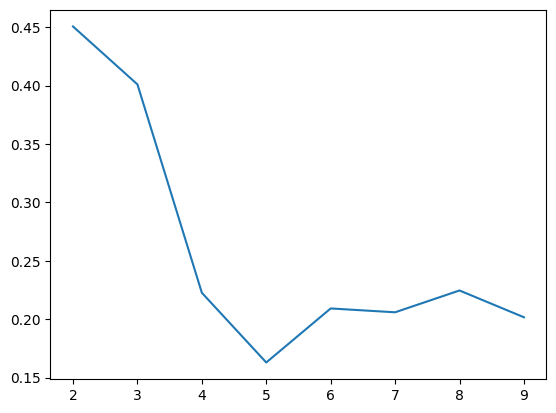

In [12]:
fig, ax = plt.subplots(1,1)
ax.plot(costs.keys(), costs.values())
plt.show()

## Classification
### Logistic Regression

In [13]:
lr = LogisticRegression()
grid = ParamGridBuilder().addGrid(lr.maxIter, [i for i in range(10)]).build()
evaluator = BinaryClassificationEvaluator()
tvs = TrainValidationSplit(estimator=lr, estimatorParamMaps=grid, evaluator=evaluator, parallelism=1, seed=42, trainRatio=.7)
tvsModel = tvs.fit(df_modeling)

In [14]:
evaluator.evaluate(tvsModel.transform(df_modeling))

0.9356386576415351

In [15]:
tvsModel.bestModel.explainParam('maxIter')

'maxIter: max number of iterations (>= 0). (default: 100, current: 5)'

In [16]:
tvsModel.bestModel.summary.areaUnderROC

0.9356394714036917

### Decision Tree

In [17]:
dt = DecisionTreeClassifier()
grid_dt = ParamGridBuilder().addGrid(dt.minInstancesPerNode, [1, 2]).addGrid(dt.impurity, ['gini', 'entropy']).build()
evaluator_dt = BinaryClassificationEvaluator()
tvs_dt = TrainValidationSplit(estimator=dt, estimatorParamMaps=grid_dt, evaluator=evaluator_dt, parallelism=1, seed=42, trainRatio=.7)
tvsModel_dt = tvs_dt.fit(df_modeling)

In [18]:
evaluator_dt.evaluate(tvsModel_dt.transform(df_modeling))

0.8826504168585102

In [19]:
tvsModel_dt.bestModel.explainParam('minInstancesPerNode')

'minInstancesPerNode: Minimum number of instances each child must have after split. If a split causes the left or right child to have fewer than minInstancesPerNode, the split will be discarded as invalid. Should be >= 1. (default: 1, current: 1)'

In [20]:
tvsModel_dt.bestModel.explainParam('impurity')

'impurity: Criterion used for information gain calculation (case-insensitive). Supported options: entropy, gini (default: gini, current: entropy)'

In [21]:
tvsModel_dt.bestModel.featureImportances

SparseVector(53, {0: 0.0004, 28: 0.0018, 33: 0.0098, 34: 0.0178, 42: 0.0005, 44: 0.5236, 46: 0.0218, 47: 0.0004, 50: 0.0888, 51: 0.009, 52: 0.3261})

### Linear SVC

In [22]:
svc = LinearSVC()
grid_svc = ParamGridBuilder().addGrid(svc.maxIter, [100]).build()
evaluator_svc = BinaryClassificationEvaluator()
tvs_svc = TrainValidationSplit(estimator=svc, estimatorParamMaps=grid_svc, evaluator=evaluator_svc, parallelism=1, seed=42, trainRatio=.7)
tvsModel_svc = tvs_svc.fit(df_modeling)

In [23]:
tvsModel_svc.bestModel.summary().areaUnderROC

0.9333724980941464

In [24]:
tvsModel_svc.bestModel.coefficients

DenseVector([0.082, -0.0063, 0.061, 0.0076, 0.0282, 0.1277, 0.0025, 0.0018, 0.0647, 0.0486, 0.1004, 0.0086, 0.0148, 0.0054, 0.0147, -0.0208, -0.0118, 0.0012, -0.0316, 0.0396, -0.0282, 0.0614, -0.0614, -0.0175, -0.0051, -0.0181, -0.0363, 0.1929, -0.274, -0.0453, 0.0305, -0.0693, -0.1882, -0.131, -0.1298, -0.1073, 0.4045, 0.0088, -0.0572, 0.0544, 0.034, -0.5493, -0.716, -0.0038, 0.4679, -0.0461, -0.1871, -0.0051, -0.2559, 0.1784, 0.0578, -0.0972, -0.0559])

### Gradient Boosted Trees

In [25]:
gbt = GBTClassifier()
grid_gbt = ParamGridBuilder().addGrid(gbt.lossType, ['logistic']).build()
evaluator_gbt = BinaryClassificationEvaluator()
tvs_gbt = TrainValidationSplit(estimator=gbt, estimatorParamMaps=grid_gbt, evaluator=evaluator_gbt, parallelism=1, seed=42, trainRatio=.7)
tvsModel_gbt = tvs_gbt.fit(df_modeling)

22/11/16 00:57:45 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/11/16 00:57:45 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


In [26]:
tvsModel_gbt.bestModel.featureImportances

SparseVector(53, {0: 0.002, 1: 0.0033, 2: 0.0029, 4: 0.0016, 5: 0.0013, 7: 0.0015, 8: 0.0027, 9: 0.0011, 10: 0.0012, 11: 0.0, 12: 0.0016, 13: 0.0003, 14: 0.0023, 15: 0.0005, 16: 0.0022, 17: 0.0002, 18: 0.0068, 19: 0.0023, 21: 0.007, 23: 0.0004, 24: 0.0, 25: 0.0004, 26: 0.0027, 27: 0.0182, 28: 0.0094, 29: 0.0006, 30: 0.0007, 31: 0.0008, 32: 0.0006, 33: 0.0114, 34: 0.0114, 35: 0.0004, 36: 0.0037, 37: 0.0011, 38: 0.0035, 39: 0.0034, 40: 0.0094, 42: 0.0141, 43: 0.0389, 44: 0.4199, 45: 0.0175, 46: 0.0387, 47: 0.0068, 48: 0.0189, 49: 0.0191, 50: 0.0373, 51: 0.0832, 52: 0.1861})

In [27]:
evaluator_gbt.evaluate(tvsModel_gbt.transform(df_modeling))

0.9517242647128198

### Factorization Machines

In [28]:
fm = FMClassifier()
grid_fm = ParamGridBuilder().addGrid(fm.solver, ['adamW']).build()
evaluator_fm = BinaryClassificationEvaluator()
tvs_fm = TrainValidationSplit(estimator=fm, estimatorParamMaps=grid_fm, evaluator=evaluator_fm, parallelism=1, seed=42, trainRatio=.7)
tvsModel_fm = tvs_fm.fit(df_modeling)

In [29]:
tvsModel_fm.bestModel.summary().areaUnderROC

0.7550807712012169

## Serialize champion

In [30]:
tvsModel_gbt.save(r'../models/gbt')